... loading data


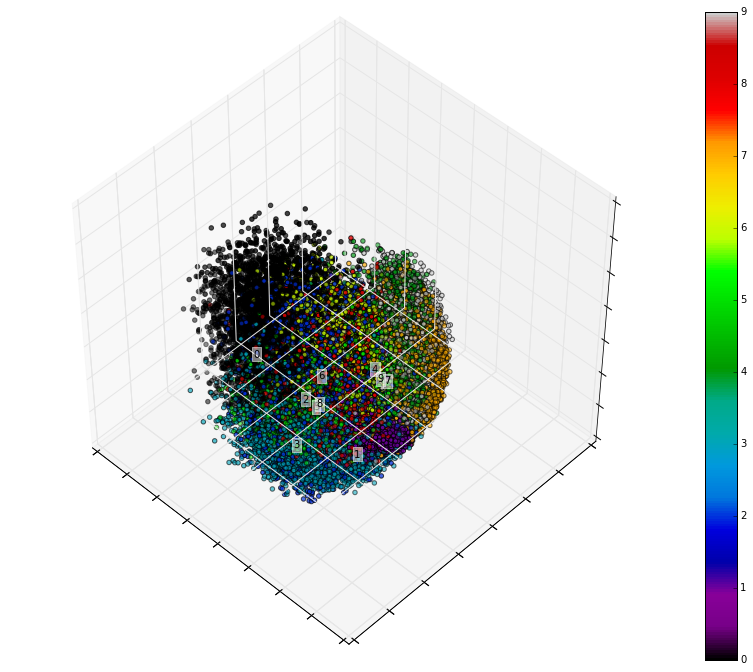

In [38]:
%matplotlib inline
import os, sys
import theano
import theano.tensor as T
from logistic_sgd import LogisticRegression, load_data
import numpy as np
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)
dataset = 'mnist.pkl.gz'
mnist = load_data(dataset)
X, y = mnist[0] # training dataset
X = X.get_value()
y = y.eval()

fig = pl.figure(1, figsize=(12,9))
pl.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
pl.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
centers = [[1, 1], [-1, -1], [1, -1]]

for number in range(10):
    ax.text3D(X[y == number, 0].mean(),
              X[y == number, 1].mean() + 1.5,
              X[y == number, 2].mean(), str(number),
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),
             )
# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(np.float)
#ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=pl.cm.spectral)
p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=pl.cm.spectral)
pl.colorbar(p)

x_surf = [X[:, 0].min(), X[:, 0].max(),
          X[:, 0].min(), X[:, 0].max()]
y_surf = [X[:, 0].max(), X[:, 0].max(),
          X[:, 0].min(), X[:, 0].min()]
x_surf = np.array(x_surf)
y_surf = np.array(y_surf)
v0 = pca.transform(pca.components_[0])
v0 /= v0[-1]
v1 = pca.transform(pca.components_[1])
v1 /= v1[-1]

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

pl.show()


... loading data


Using gpu device 0: GeForce GTX 980


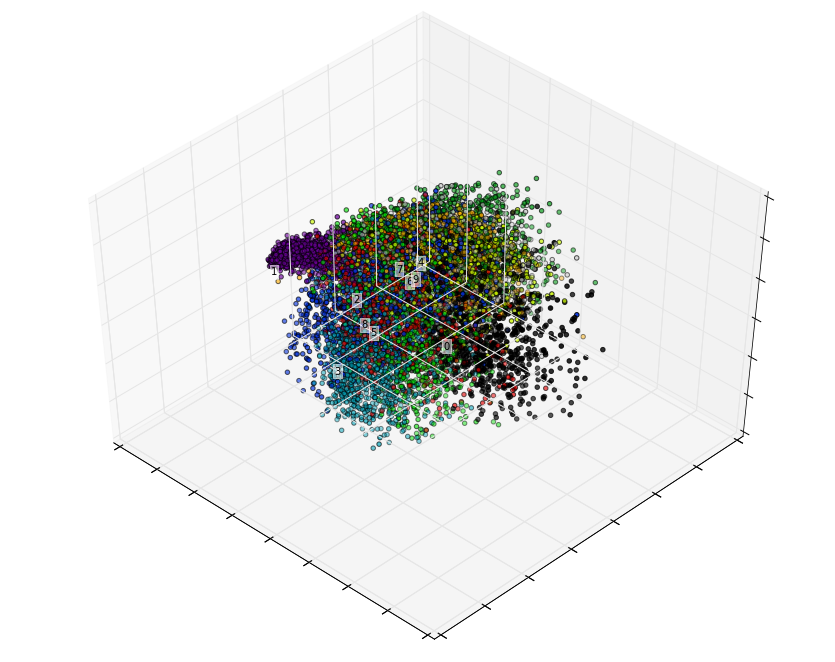

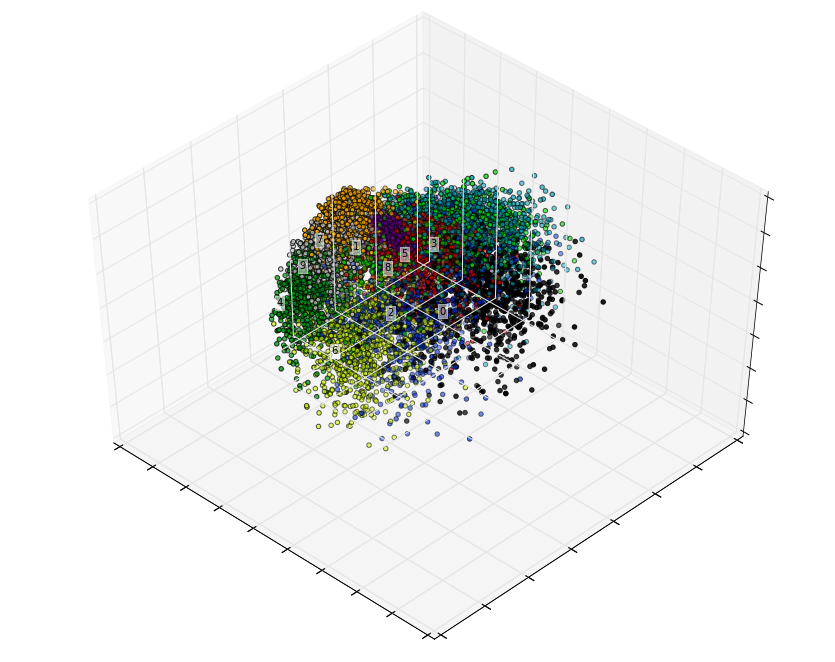

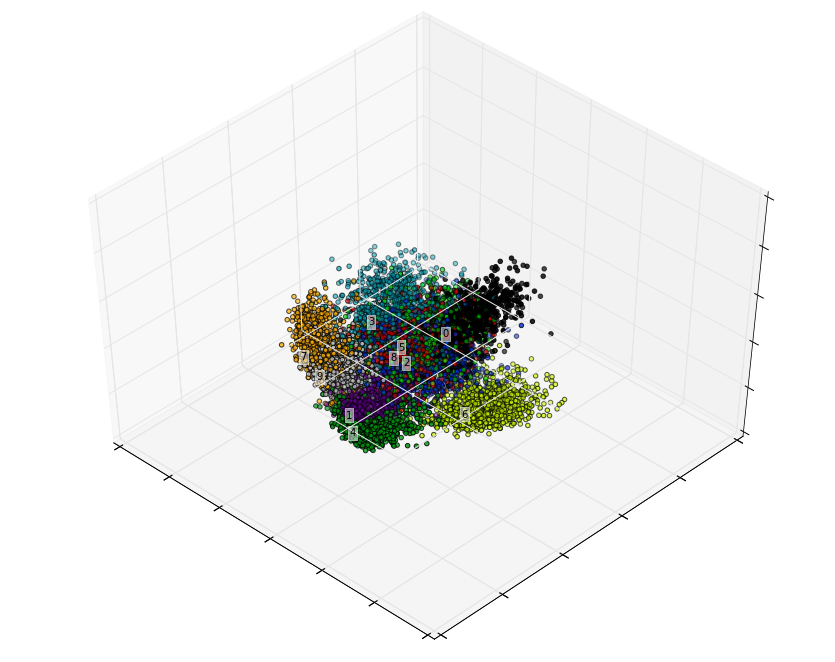

In [1]:
%matplotlib inline
import os,sys,time
import gzip, cPickle

import numpy, scipy, matplotlib
import pylab as pl

import theano
import theano.tensor as T

from logistic_sgd import LogisticRegression, load_data

from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def ReLU(X):
    return T.maximum(X, 0.)

# start-snippet-1
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None, activation=ReLU):
        self.input = input

        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


# start-snippet-2
class MLP(object):
    def __init__(self, rng, input, n_in, hidden_layer_sizes, n_out):
        self.hiddenLayers = []
        self.hiddenLayers.append( HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=hidden_layer_sizes[0],
            activation=ReLU
            )
        )

        for idx, size in enumerate(hidden_layer_sizes):
            self.hiddenLayers.append( HiddenLayer(
                    rng=rng,
                    input=self.hiddenLayers[idx].output,
                    n_in=hidden_layer_sizes[idx],
                    n_out=hidden_layer_sizes[idx+1],
                    activation=ReLU
                )
            )
            if idx+1 == len(hidden_layer_sizes)-1:
                break


        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayers[-1].output,
            n_in=hidden_layer_sizes[-1],
            n_out=n_out
        )
        # end-snippet-2 start-snippet-3
        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = (
            sum([abs(x.W).sum() for x in self.hiddenLayers])
            + abs(self.logRegressionLayer.W).sum()
        )

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (
            sum([(x.W **2).sum() for x in self.hiddenLayers])
            + (self.logRegressionLayer.W ** 2).sum()
        )

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        #self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        self.params = self.logRegressionLayer.params
        for layer in self.hiddenLayers:
            self.params += layer.params
        # end-snippet-3


def test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000,
             dataset='mnist.pkl.gz', batch_size=20, hidden_layer_sizes=[100,100], seed=1234, model='../model/2layerReLUmodel-100-100'):
    model = model + '-seed-' + str(seed) + '.dat'
    datasets = load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(seed)

    # construct the MLP class
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=28 * 28,
        hidden_layer_sizes=hidden_layer_sizes,
        n_out=10
    )

    with open(model, 'r') as f:
        for i, param in enumerate(classifier.params):
            classifier.params[i].set_value(cPickle.load(f), borrow=True)
    
    hid1 = ReLU(T.dot(test_set_x, classifier.params[2]) + classifier.params[3])
    hid2 = ReLU(T.dot(hid1, classifier.params[4]) + classifier.params[5])
    out10 = T.nnet.softmax(T.dot(hid2, classifier.params[0]) + classifier.params[1])
    pred = T.argmax(out10, axis=1)

    #X = test_set_x.get_value()
    #y = test_set_y.eval()

    y = test_set_y.eval()
    
    for X in [test_set_x.get_value(), hid1.eval(), hid2.eval()]:
        fig = pl.figure(1, figsize=(12,9))
        pl.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
        pl.cla()
        pca = decomposition.PCA(n_components=3)
        pca.fit(X)
        X = pca.transform(X)
        centers = [[1, 1], [-1, -1], [1, -1]]

        for number in range(10):
            ax.text3D(X[y == number, 0].mean(),
                      X[y == number, 1].mean() + 1.5,
                      X[y == number, 2].mean(), str(number),
                      horizontalalignment='center',
                      bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),
                     )
        # Reorder the labels to have colors matching the cluster results
        #y = np.choose(y, [1, 2, 0]).astype(np.float)
        #ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=pl.cm.spectral)
        p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=pl.cm.spectral)
        #pl.colorbar(p)

        x_surf = [X[:, 0].min(), X[:, 0].max(), X[:, 0].min(), X[:, 0].max()]
        y_surf = [X[:, 0].max(), X[:, 0].max(), X[:, 0].min(), X[:, 0].min()]
        x_surf = numpy.array(x_surf)
        y_surf = numpy.array(y_surf)
        v0 = pca.transform(pca.components_[0])
        v0 /= v0[-1]
        v1 = pca.transform(pca.components_[1])
        v1 /= v1[-1]

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        
        pl.show()
        
if __name__ == '__main__':
    test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=2000, dataset='mnist.pkl.gz', batch_size=20, hidden_layer_sizes=[500,500], seed=20, model='../model/2layer-ReLUmodel-500-500')    

In [3]:
%matplotlib inline
import theano
from theano import tensor as T
from theano.tensor.nnet import conv

import numpy

rng = numpy.random.RandomState(23455)

# instantiate 4D tensor for input
input = T.tensor4(name='input')

# initialize shared variable for weights.
w_shp = (3, 1, 3, 3)
w_bound = numpy.sqrt(1 * 3 * 3)
import scipy
size=1
x,y = scipy.mgrid[-size:size+1,-size:size+1]
gg = scipy.exp(-(x**2/float(size)+y**2/float(size)))
gg /= gg.sum()

W = theano.shared( numpy.asarray(
        [[
            [ [-1,0,1], [-2,0,2], [-1,0,1] ],
                ],
         [
            [ [-1,-2,-1], [0,0,0], [1,2,1] ],
                ],
         [
            [ [-1,-1,-1], [-1,8,-1], [-1,-1,-1] ],
                ],
         [
            gg,
                ],
         [
            [ [0,-1,0], [-1,5,-1], [0,-1,0] ],
                ],
        ],
        dtype=input.dtype
        ), name = 'W')
'''
W = theano.shared( numpy.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=input.dtype), name ='W')
'''
b_shp = (5,)
b = theano.shared(numpy.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=input.dtype), name ='b')

# build symbolic expression that computes the convolution of input with filters in w
conv_out = conv.conv2d(input, W)
output = T.nnet.sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))

# create theano function to compute filtered images
f = theano.function([input], output, allow_input_downcast=True)

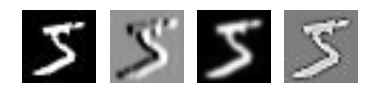

In [7]:
import numpy
import pylab
from PIL import Image

# open random image of dimensions 639x516
img = Image.open(open('../resource/original/train-00000-5.jpg'))
#img = Image.open(open('../rgb.png'))
# dimensions are (height, width, channel)
img = numpy.asarray(img, dtype='float64') / 256.

# put image in 4D tensor of shape (1, 3, height, width)
img_ = img.reshape(1, 1, 28, 28)
filtered_img = f(img_)

# plot original image and first and second components of output
pylab.subplot(1, 4, 1); pylab.axis('off'); pylab.imshow(img) # original
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 4, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :]) # sobel
#pylab.subplot(1, 6, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 1, :, :]) # sobel
#pylab.subplot(1, 6, 4); pylab.axis('off'); pylab.imshow(filtered_img[0, 2, :, :]) # edge detection
pylab.subplot(1, 4, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 3, :, :]) # gaussian blur
pylab.subplot(1, 4, 4); pylab.axis('off'); pylab.imshow(filtered_img[0, 4, :, :]) # sharpen
pylab.show()